In [1]:
#1 imports
from pathlib import Path

#file paths
ROOT = ROOT = Path.cwd().parent
RAW_DIR = ROOT/"data"/"raw"
PROCESSED_DIR = ROOT/"data"/"processed"

import sys, os
import pandas as pd
import numpy as np

sys.path.insert(0, os.path.abspath("..")) #preprocess at root
from preprocess import load_csv, save_csv, split_data

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

print("Imports loaded")

Imports loaded


In [2]:
#2.1 load data
df = load_csv(RAW_DIR, "data02.csv")

print(df.head()) #first 5 rows

Loaded data02.csv: length: 11914 

  Make       Model  Year             Engine Fuel Type  Engine HP  \
0  BMW  1 Series M  2011  premium unleaded (required)      335.0   
1  BMW    1 Series  2011  premium unleaded (required)      300.0   
2  BMW    1 Series  2011  premium unleaded (required)      300.0   
3  BMW    1 Series  2011  premium unleaded (required)      230.0   
4  BMW    1 Series  2011  premium unleaded (required)      230.0   

   Engine Cylinders Transmission Type     Driven_Wheels  Number of Doors  \
0               6.0            MANUAL  rear wheel drive              2.0   
1               6.0            MANUAL  rear wheel drive              2.0   
2               6.0            MANUAL  rear wheel drive              2.0   
3               6.0            MANUAL  rear wheel drive              2.0   
4               6.0            MANUAL  rear wheel drive              2.0   

                         Market Category Vehicle Size Vehicle Style  \
0  Factory Tuner,Luxury,High

In [3]:
#2.2 clean data
df.columns = df.columns.str.lower().str.replace(' ', '_') #lowercase, replace spaces in col names

string_columns = list(df.dtypes[df.dtypes == 'object'].index) #keep only string cols
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

save_csv(df, PROCESSED_DIR, "data02_cleaned.csv")
df.head()

Saved data02_cleaned.csv


,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


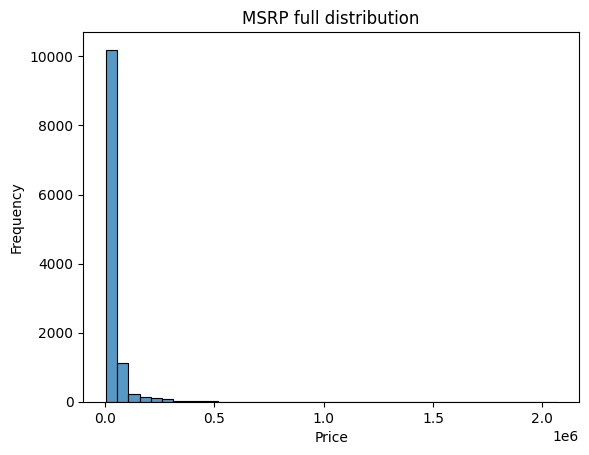

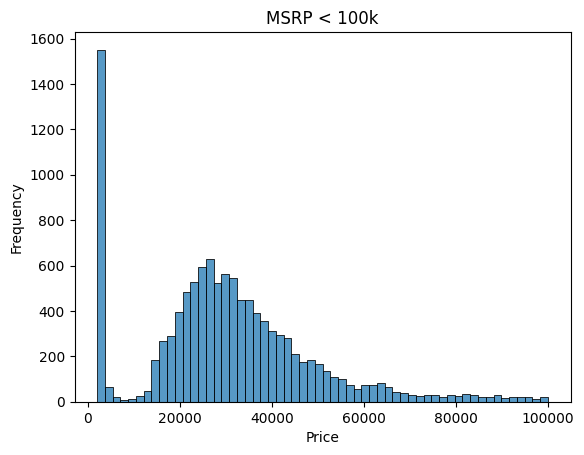

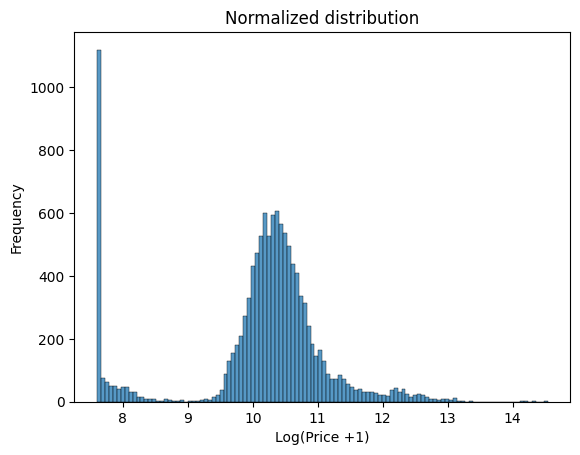

In [4]:
#2.3 check target (MSRP) distribution
sns.histplot(df.msrp, bins=40).set(title="MSRP full distribution", xlabel="Price", ylabel="Frequency")
plt.show()

sns.histplot(df.msrp[df.msrp < 100000]).set(title="MSRP < 100k", xlabel="Price", ylabel="Frequency")
plt.show()

#apply log transformation to prevent large values from dominating training: y_new = log(y+1)
log_price = np.log1p(df.msrp)
sns.histplot(log_price).set(title="Normalized distribution", xlabel="Log(Price +1)", ylabel="Frequency")
plt.show()

[Text(0.5, 1.0, 'Normalized distribution')]

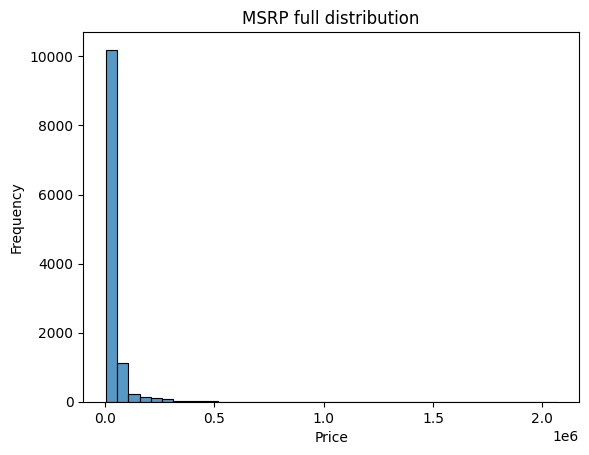

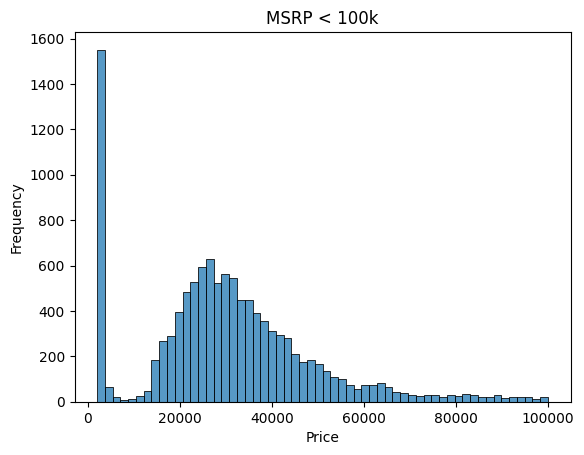

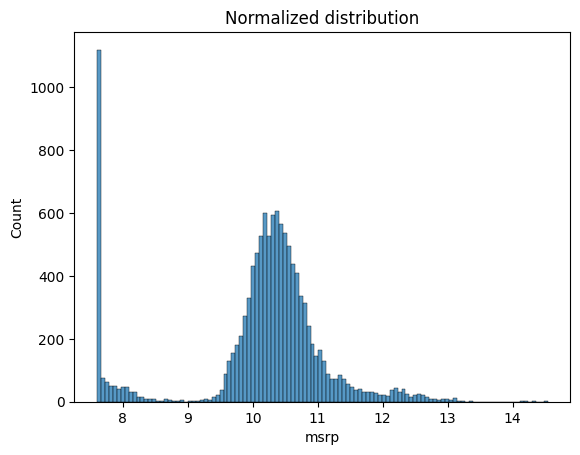

In [5]:
# 4 check target (MSRP) distribution

plt.figure()
sns.histplot(df.msrp, bins=40).set(title="MSRP full distribution", xlabel="Price", ylabel="Frequency")

plt.figure()
sns.histplot(df.msrp[df.msrp < 100000]).set(title = "MSRP < 100k", xlabel="Price", ylabel="Frequency")

#apply log transformation to prevent large values from dominating training: y_new = log(y+1)
log_price = np.log1p(df.msrp)
plt.figure()
sns.histplot(log_price).set(title = "Normalized distribution")

In [6]:
#2.4 check for missing values
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

In [10]:
#2.5 validation framwork
df_clean = load_csv(PROCESSED_DIR, "data02_cleaned.csv") #load cleaned data

df_train, df_val, df_test = split_data(df_clean) #split sets

#apply log transforms to msrp
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

Loaded data02_cleaned.csv: length: 11914 


before shuffle [    0     1     2 ... 11911 11912 11913]

after shuffle [2735 6720 5878 ... 6637 2575 7336]


In [16]:
#3. implement linear regression model for training
#learn linear model from X features and y target
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])    #bias column: create vector of 1s, n rows in X
    X = np.column_stack([ones, X]) #add biased column to the left of X

    XTX = X.T.dot(X)             #Gram matrix: cross product of columns
    XTX_inv = np.linalg.inv(XTX) #inverse of XTX - lets us solve for weights
    w = XTX_inv.dot(X.T).dot(y)  #normal equation: find weight that minimize mean squared error

    #w0: intercept - the models baseline prediction
    #w[1:]: vector of feature weights w
    return w[0], w[1:]

#normal built in equivalent:
#from sklearn.linear_model import LinearRegression
#lr = LinearRegression(fit_intercept=True).fit(X_train, y_train)
#w0 = lr.intercept_
#w  = lr.coef_


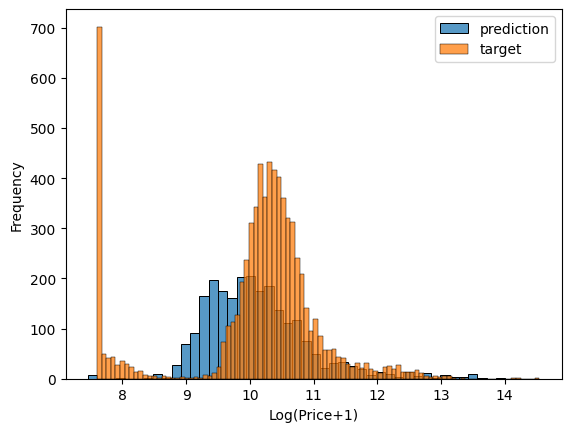

In [27]:
#4. Prediction
#4.1 Baseline
#base feature list
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']

def prepare_X(df):
    df_num = df[base]         #basline df
    df_num = df_num.fillna(0) #fill missing values with 0. not best but simple and good enough  
    X = df_num.values         #convert df to 2D np array

    return X

#train model
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train) #run linear regression

#apply to training dataset to check prediction
y_pred_train = w_0 + X_train.dot(w)

#view prediction vs target
sns.histplot(y_pred, label='prediction')
sns.histplot(y_train, label='target')
plt.legend()
plt.xlabel('Log(Price+1)')
plt.ylabel('Frequency')

plt.show()

In [28]:
#4.2 model quality
#RMSE: how larger errors are
def rmse(y, y_pred):
    error = y_pred - y        #array with differences between predicted vals vs actual vals
    mse = (error ** 2).mean() #squre errors then average
    return np.sqrt(mse)       #sqrt of mse

#4.3 eval model quality
print('amount off training set:', rmse(y_train, y_pred_train)) #display how far model is off

#apply model to validation dataset
X_val = prepare_X(df_val)
y_pred_val = w_0 + X_val.dot(w)
print('amount off validation set:', rmse(y_val, y_pred_val)) #display how far model is off

amount off training set: 0.7554192603920132
amount off validation set: 0.761653099130156


amount off training set: 0.5175055465840046
amount off validation set: 0.5172055461058299


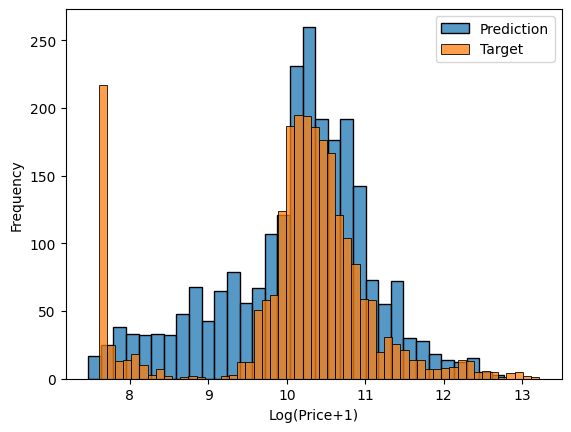

In [43]:
#4.4 improve model by adding more features
def prepare_X(df):
    df = df.copy()          #copy of input df
    features = base.copy() #copy of base features

    df['age'] = 2017 - df.year #compute vehicle age, dataset created 2017
    features.append('age')     #add age to feature list

    df_num =df[features] #df with age added
    df_num=df_num.fillna(0)
    X = df_num.values

    return X

#train with new features
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

#eval new features
y_pred_train = w_0 + X_train.dot(w) #apply to training dataset
print('amount off training set:', rmse(y_train, y_pred_train)) #display how far model is off

#apply to validation dataset
X_val = prepare_X(df_val)
y_pred_val = w_0 + X_val.dot(w)
print('amount off validation set:', rmse(y_val, y_pred_val)) #display how far model is off

#plot distribtution
sns.histplot(y_pred_val, label='Prediction')
sns.histplot(y_val, label='Target')

plt.legend()
plt.xlabel('Log(Price+1)')
plt.ylabel('Frequency')

plt.show()

In [48]:
#4.5 catigorical values
#find top 5 makes
top5_counts = df['make'].value_counts().head(5)
print(top5_counts, "\n")

top5_makes = top5_counts.index.tolist()
print(top5_makes)

make
chevrolet     1123
ford           881
volkswagen     809
toyota         746
dodge          626
Name: count, dtype: int64 

['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']


In [63]:
#doors and makes for features
def add_features(df, col, values, prefix):
    cols = []
    for v in values:
        c = f"{prefix}_v"
        df[c] = (df[col] == v).astype(int)
        cols.append(c)

    return cols

def prepare_X(df):
    df = df.copy()          #copy of input df
    features = base.copy() #copy of base features

    df['age'] = 2017 - df.year #compute vehicle age, dataset created 2017
    features.append('age')     #add age to feature list

    #number of doors (possible values; 2, 3, 4)
    for v in [2, 3, 4]:
        num_doors = 'num_doors_%s' % v                           #feature name for v num of doors
        df[num_doors] = (df['number_of_doors'] == v).astype(int) #one-hot encoding
        features.append(num_doors)

    #top 5 makes
    for v in top5_makes:
        makes = 'is_make_%s' % v
        df[makes] = (df['make'] == v).astype(int)
        features.append(makes)

    df_num =df[features] #df with new features
    df_num=df_num.fillna(0)
    X = df_num.values

    return X

#train with new features
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

#eval new features
y_pred_train = w_0 + X_train.dot(w) #apply to training dataset
print('amount off training set:', rmse(y_train, y_pred_train)) #display how far model is off

#apply to validation dataset
X_val = prepare_X(df_val)
y_pred_val = w_0 + X_val.dot(w)
print('amount off validation set:', rmse(y_val, y_pred_val)) #display how far model is off

amount off training set: 0.5058876515487503
amount off validation set: 0.5076038849556795


In [73]:
fuels = df['engine_fuel_type'].value_counts().head().index.tolist()
print("fuels:", fuels)

trans = df['transmission_type'].value_counts().head().index.tolist()
print("transmissions:", trans)

wheels = df['driven_wheels'].value_counts().head().index.tolist()
print("driven wheels:", wheels)

category = df['market_category'].value_counts().head().index.tolist()
print("market category:", category)

size = df['vehicle_size'].value_counts().head().index.tolist()
print("vehicle size:", trans)

style = df['vehicle_style'].value_counts().head().index.tolist()
print("vehicle style:", style)

fuels: ['regular_unleaded', 'premium_unleaded_(required)', 'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)', 'diesel']
transmissions: ['automatic', 'manual', 'automated_manual', 'direct_drive', 'unknown']
driven wheels: ['front_wheel_drive', 'rear_wheel_drive', 'all_wheel_drive', 'four_wheel_drive']
market category: ['crossover', 'flex_fuel', 'luxury', 'luxury,performance', 'hatchback']
vehicle size: ['automatic', 'manual', 'automated_manual', 'direct_drive', 'unknown']
vehicle style: ['sedan', '4dr_suv', 'coupe', 'convertible', '4dr_hatchback']


In [70]:
#add fuel types, trans, num drive wheels, category, size, style
#doors and makes for features
def prepare_X(df):
    df = df.copy()          #copy of input df
    features = base.copy() #copy of base features

    df['age'] = 2017 - df.year #compute vehicle age, dataset created 2017
    features.append('age')     #add age to feature list

    #number of doors (possible values; 2, 3, 4)
    for v in [2, 3, 4]:
        num_doors = 'num_doors_%s' % v                           #feature name for v num of doors
        df[num_doors] = (df['number_of_doors'] == v).astype(int) #one-hot encoding
        features.append(num_doors)

    #top 5 makes
    for v in top5_makes:
        makes = 'is_make_%s' % v
        df[makes] = (df['make'] == v).astype(int)
        features.append(makes)

    #top fuel
    for v in fuels:
        fuel = 'is_type_%s' % v
        df[makes] = (df['engine_fuel_type'] == v).astype(int)
        features.append(fuel)

    for v in trans:
        trans = 'is_transmission_%s' % v
        df[trans] = (df['transmission_type'] == v).astype(int)
        features.append(trans)

    for v in wheels:
        wheels = 'is_driven_wheens_%s' % v
        df[wheels] = (df['driven_wheels'] == v).astype(int)
        features.append(wheels)

    for v in category:
        category = 'is_mc_%s' % v
        df[category] = (df['market_category'] == v).astype(int)
        features.append(category)

    for v in size:
        size = 'is_size_%s' % v
        df[size] = (df['vehicle_size'] == v).astype(int)
        features.append(size)

    for v in style:
        style = 'is_style_%s' % v
        df[style] = (df['vehicle_style'] == v).astype(int)
        features.append(style)

    df_num =df[features] #df with new features
    df_num=df_num.fillna(0)
    X = df_num.values

    return X

#train with new features
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

#eval new features
y_pred_train = w_0 + X_train.dot(w) #apply to training dataset
print('amount off training set:', rmse(y_train, y_pred_train)) #display how far model is off

#apply to validation dataset
X_val = prepare_X(df_val)
y_pred_val = w_0 + X_val.dot(w)
print('amount off validation set:', rmse(y_val, y_pred_val)) #display how far model is off

UnboundLocalError: cannot access local variable 'trans' where it is not associated with a value